# Step 0: Select any GPU for your runtime

# Step 1: Requirements

In [ ]:
!git clone https://github.com/pablodawson/diffusers.git
import os
os.chdir("diffusers")
!pip install accelerate transformers triton datasets diffusers timm==0.9.0 tensorboard huggingface_hub opencv-python deepspeed

# Testing

**Option 1:** Starting from real image

In [ ]:
import torch

#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
import numpy as np
import cv2
from PIL import Image

filename = "/content/dog.jpeg"
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = transform(img).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()
output = (output - output.min())/(output.max()-output.min())
output = Image.fromarray((output*65000).astype(np.uint16))

depth_image = output
depth_image.save("depth.png")

rgb_image = Image.open(filename)
rgb_image.save("rgb.jpg")

**Option 2:** Starting from an original ldm3d model generation

In [ ]:
from src.diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_ldm3d import StableDiffusionLDM3DPipeline
import numpy as np
from PIL import Image

pipe = StableDiffusionLDM3DPipeline.from_pretrained("Intel/ldm3d-4c", cache_dir="cache")
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
output = pipe(prompt, num_inference_steps=30)
rgb_image, depth_image = output.rgb[0], output.depth[0]
rgb_image.save("rgb.jpg")
depth_image.save("depth.png")

Create mask with depth

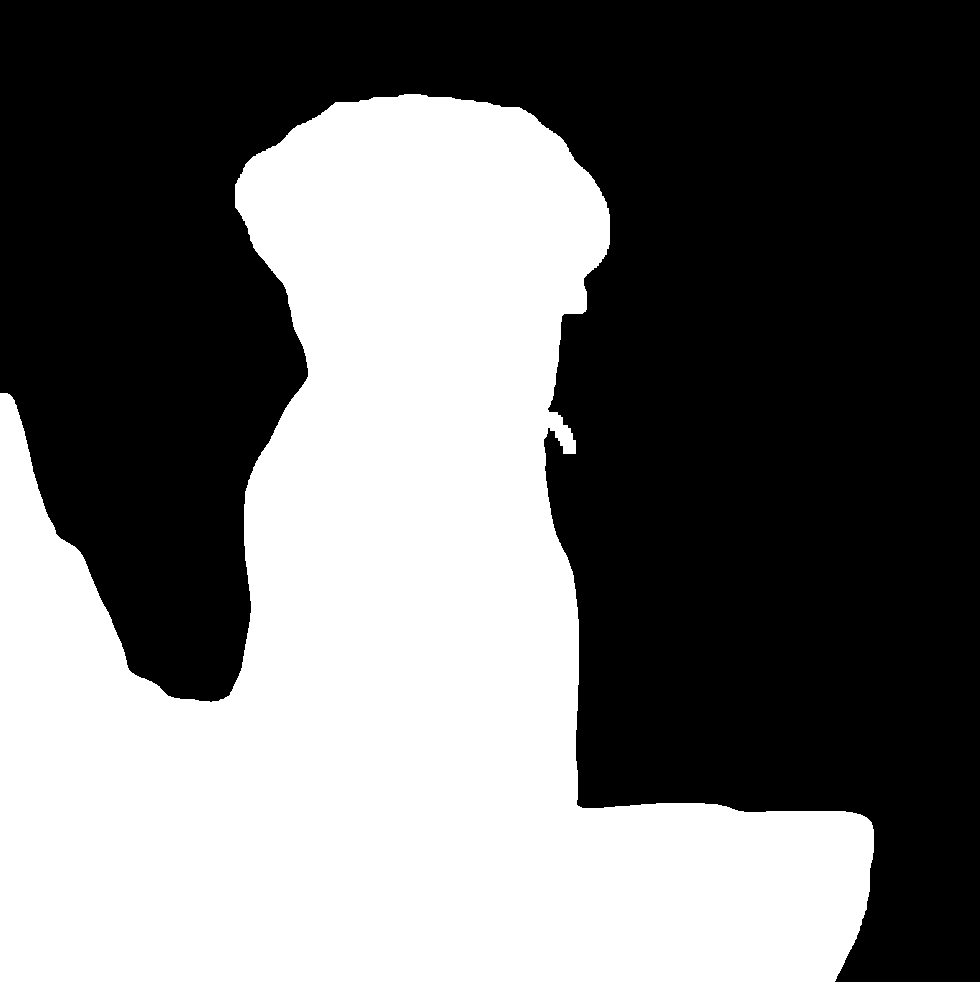

In [ ]:
threshold = 40000

mask_image = np.zeros_like(np.array(depth_image))
#dummy threshold
mask_image[np.array(depth_image) > threshold] = 65535

# Dilate the mask
kernel = np.ones((5, 5), np.uint8)
img_dilation = cv2.dilate(mask_image, kernel, iterations=3)

mask_image = Image.fromarray(img_dilation).convert("L")

mask_image.save("output_mask.png")
mask_image

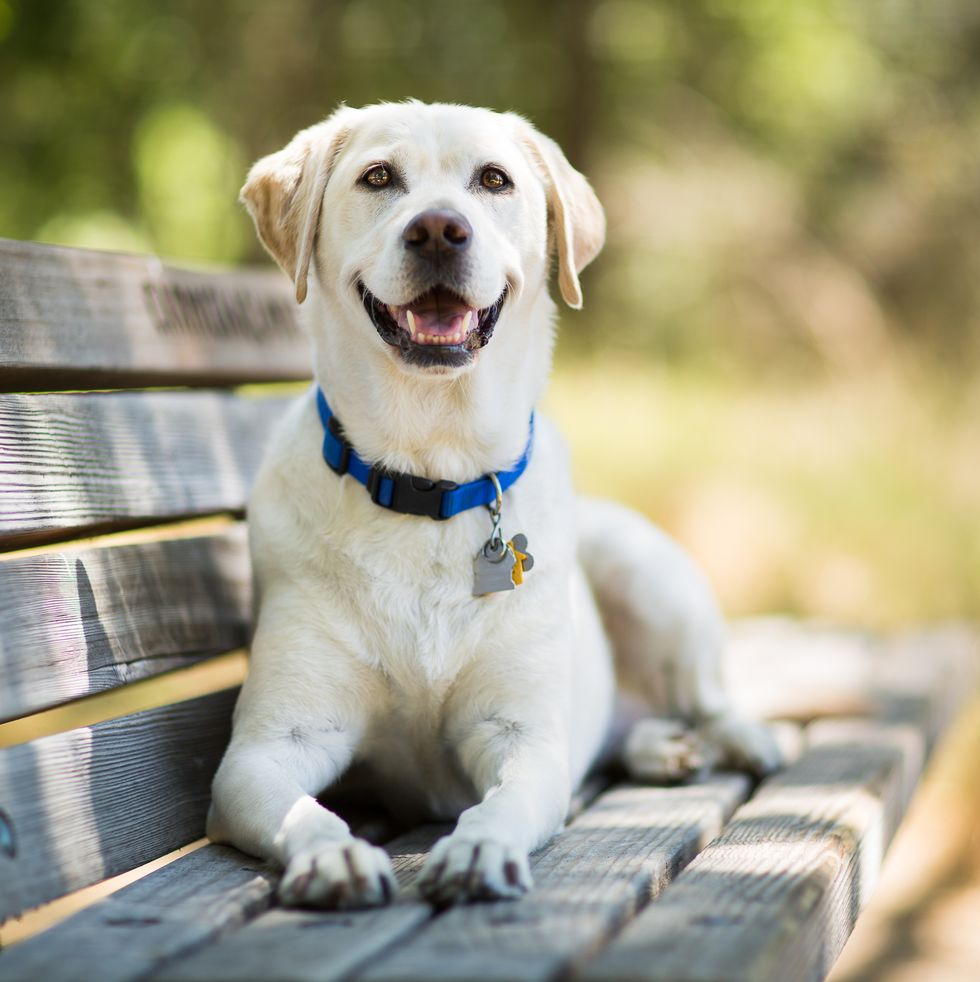

In [ ]:
rgb_image

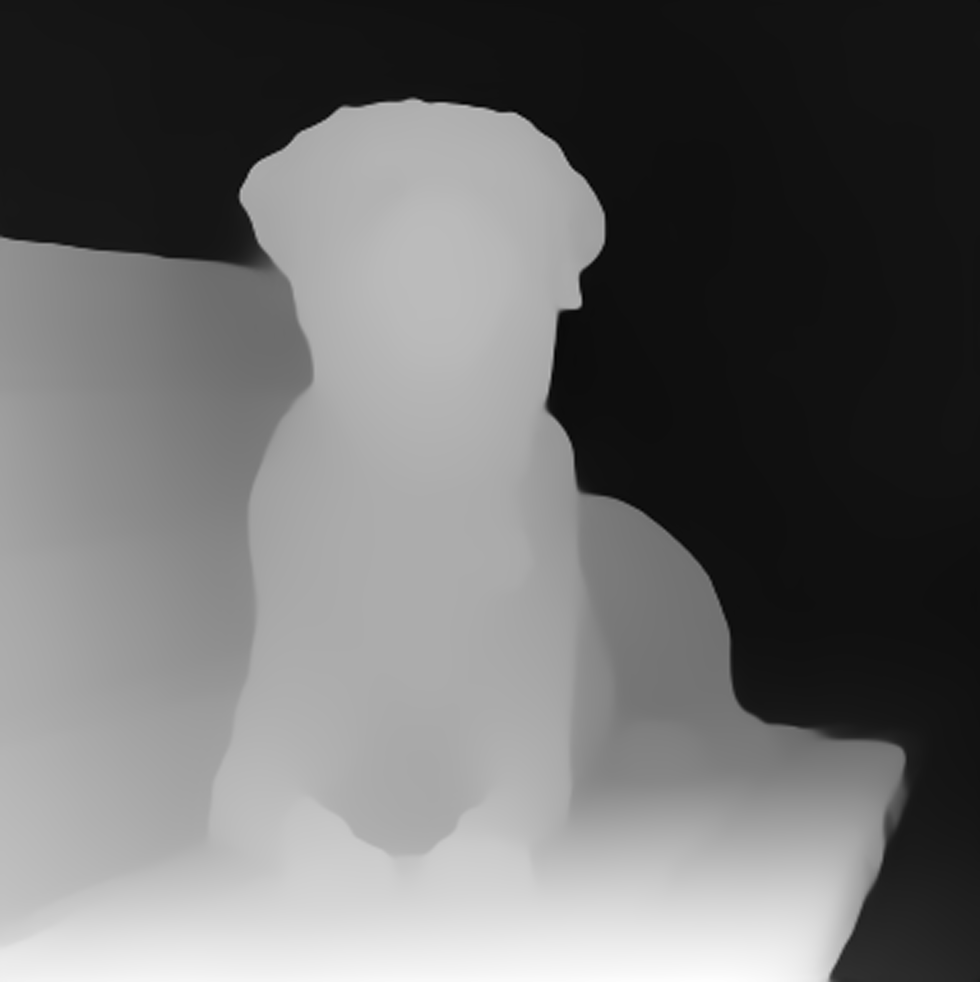

In [ ]:
depth_image

# Inpainting
Use the resulting Depth, Color and dummy mask for inpainting, or replace with your own images

In [ ]:
from src.diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_ldm3d_inpaint import StableDiffusionLDM3DInpaintPipeline
from PIL import Image
import numpy as np
from diffusers import UNet2DConditionModel

# Cargar con weights inicializados random
unet = UNet2DConditionModel.from_pretrained("pablodawson/ldm3d-inpainting", cache_dir="cache", subfolder="unet")
pipe = StableDiffusionLDM3DInpaintPipeline.from_pretrained("Intel/ldm3d-4c", cache_dir="cache" )
pipe = pipe.to("cuda")

prompt = "a photo a cat"
input_image = Image.open("rgb.jpg")
depth_image = Image.open("depth.png")
mask_image = Image.open("output_mask.png")

output = pipe(prompt=prompt, image=input_image, mask_image=mask_image, depth_image=depth_image, num_inference_steps=30, strength=1.0)

rgb = output["rgb"][0]
depth = output["depth"][0]
rgb.save("rgb_inpainted.png")
depth.save("depth_inpainted.png")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

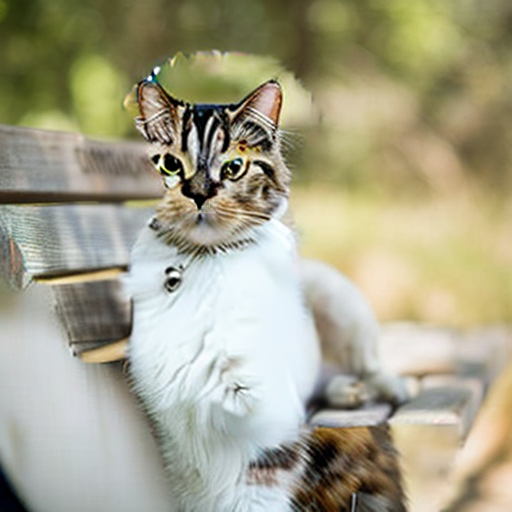

In [ ]:
rgb

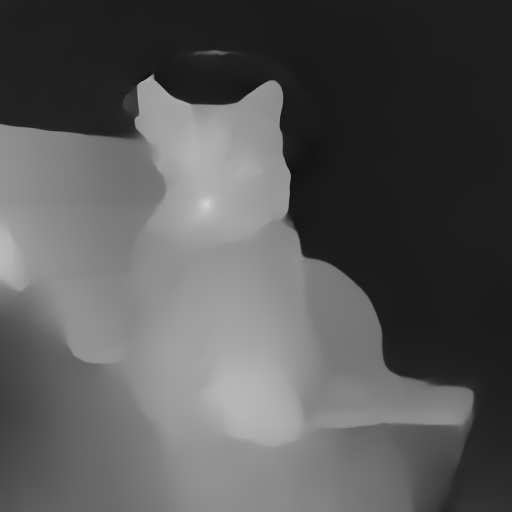

In [ ]:
depth

# Training

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/diffusers/ldm3d-inpainting

(Optional) accelerate **config**, a text box will appear

In [ ]:
!accelerate config

In [ ]:
!accelerate launch --mixed_precision="fp16" train_ldm3d_inpainting.py \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --max_train_steps=15000 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --checkpointing_steps=1000\
  --lr_scheduler="constant" --lr_warmup_steps=0